In [1]:
using Yao, YaoPlots, MAT

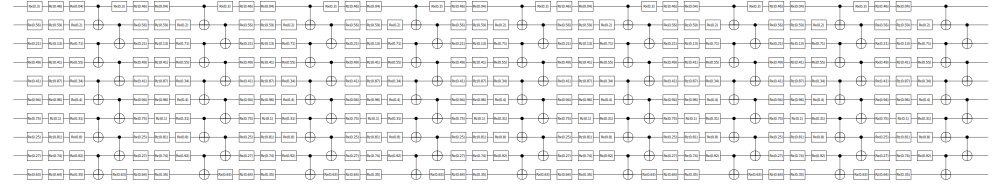

In [5]:
# import the FashionMNIST data
vars = matread("../dataset/FashionMNIST_1_2_wk.mat")
x_train = vars["x_train"]
y_train = vars["y_train"]
x_test = vars["x_test"]
y_test = vars["y_test"]
num_qubit = 10

# set the size of the training set and the test set
num_train = 500
num_test = 100
# set the scaling factor c = 2
c = 2
x_train = real(x_train[:,1:num_train])*c
y_train = y_train[1:num_train,:]
x_test = real(x_test[:,1:num_test])*c
y_test = y_test[1:num_test,:];

# define the QNN circuit, some functions have been defined before
include("../library/Layer.jl")
Ent_Layer = Ent_CX(num_qubit)
Parameterized_Layer = Params_Layer(num_qubit)
Composite_Block = chain(num_qubit, Parameterized_Layer, Ent_Layer)
depth = 9
circuit = chain(Composite_Block for _ in 1:depth)
# assign random initial parameters to the circuit
dispatch!(circuit, :random)
# record the initial parameters
ini_params = parameters(circuit);
YaoPlots.plot(circuit)

In [4]:
# we illustrate the idea of block-encoding based QNNs through a simple example
# the FashionMNIST dataset has been resized to be 256-dimensional
# we expand them to 270-dimensional by adding zeros at the end of the vectors
dim = 270
x_train_ = zeros(Float64,(dim,num_train))
x_train_[1:256,:] = x_train
x_train = x_train_
x_test_ = zeros(Float64,(dim,num_test))
x_test_[1:256,:] = x_test
x_test = x_test_

# the input data and the variational parameters are interleaved
# later we will numerically test the expressive power of this encoding strategy
train_cir = [chain(chain(num_qubit, Params_Layer(num_qubit), Ent_CX(num_qubit)) 
        for _ in 1:depth) for _ in 1:num_train]
test_cir = [chain(chain(num_qubit, Params_Layer(num_qubit), Ent_CX(num_qubit)) 
        for _ in 1:depth) for _ in 1:num_test];
for i in 1:num_train
    dispatch!(train_cir[i], x_train[:,i]+ini_params)
end
for i in 1:num_test
    dispatch!(test_cir[i], x_test[:,i]+ini_params)
end